# Agentic Corrective RAG System in LangGraph
* Notebook by Adam Lang
* Date: 10/26/2024

# Overview
* In this notebook we will go over how to implement corrective RAG in LangGraph.

# What are some key challenges in RAG systems?
1. Outdated or low-quality retrieval
* compromises performance and accuracy of RAG systems.

2. Misinformation Risk
* Leads to generation of incorrect or misleading information by LLM output.

# Solution Proposal - "CRAG"
* CRAG stands for: "Corrective Retrieval Augmented Generation"
* This aims to mitigate these issues by retrieving retrieval accuracy.
* Original paper: https://arxiv.org/abs/2406.04744
* Workflow Steps from the paper:

1. Retrieve context docs from vector DB from input query.
2. Use an LLM to check if retrieved docs are relevant to input question.
  * Use "LLM as a Judge".
3. If all docs are relevant or correct, no specific action is needed.
4. If some or ALL docs are NOT relevant (ambiguous OR incorrect), rephrase the query and search the web to get relevant contextual information.
5. Send rephrased query and context docs or information to the LLM for response generation.
* From original paper:

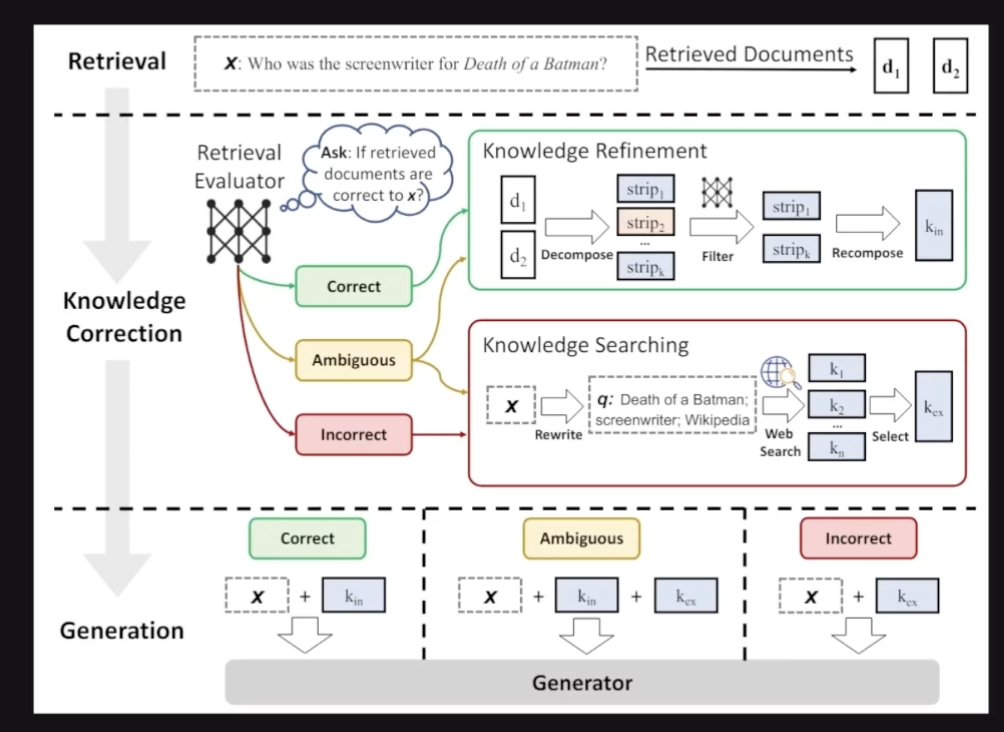

# Agentic Corrective RAG Workflow
1. Step 1 - Retrieve Node
  * Retrieves context docs from vector DB from input query.

2. Step 2 - Grade Node
  * Use LLM as a judge to grade if retrieved docs are relevant to input question - YES or NO.

3. Step 3A - Generate Answer Node

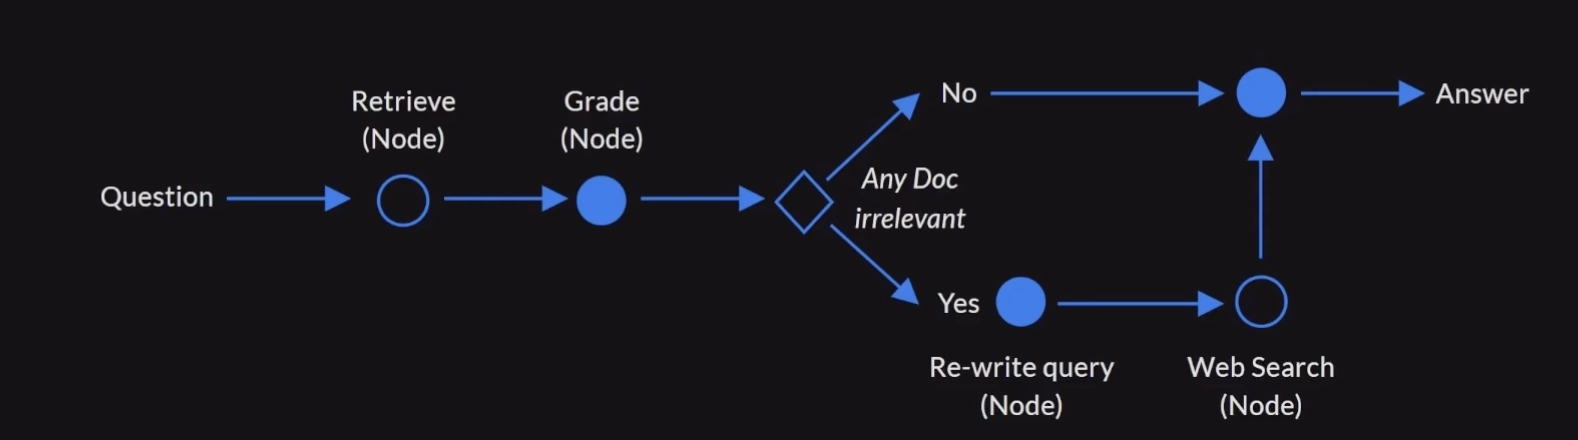

## Detailed Agentic Corrective RAG Workflow
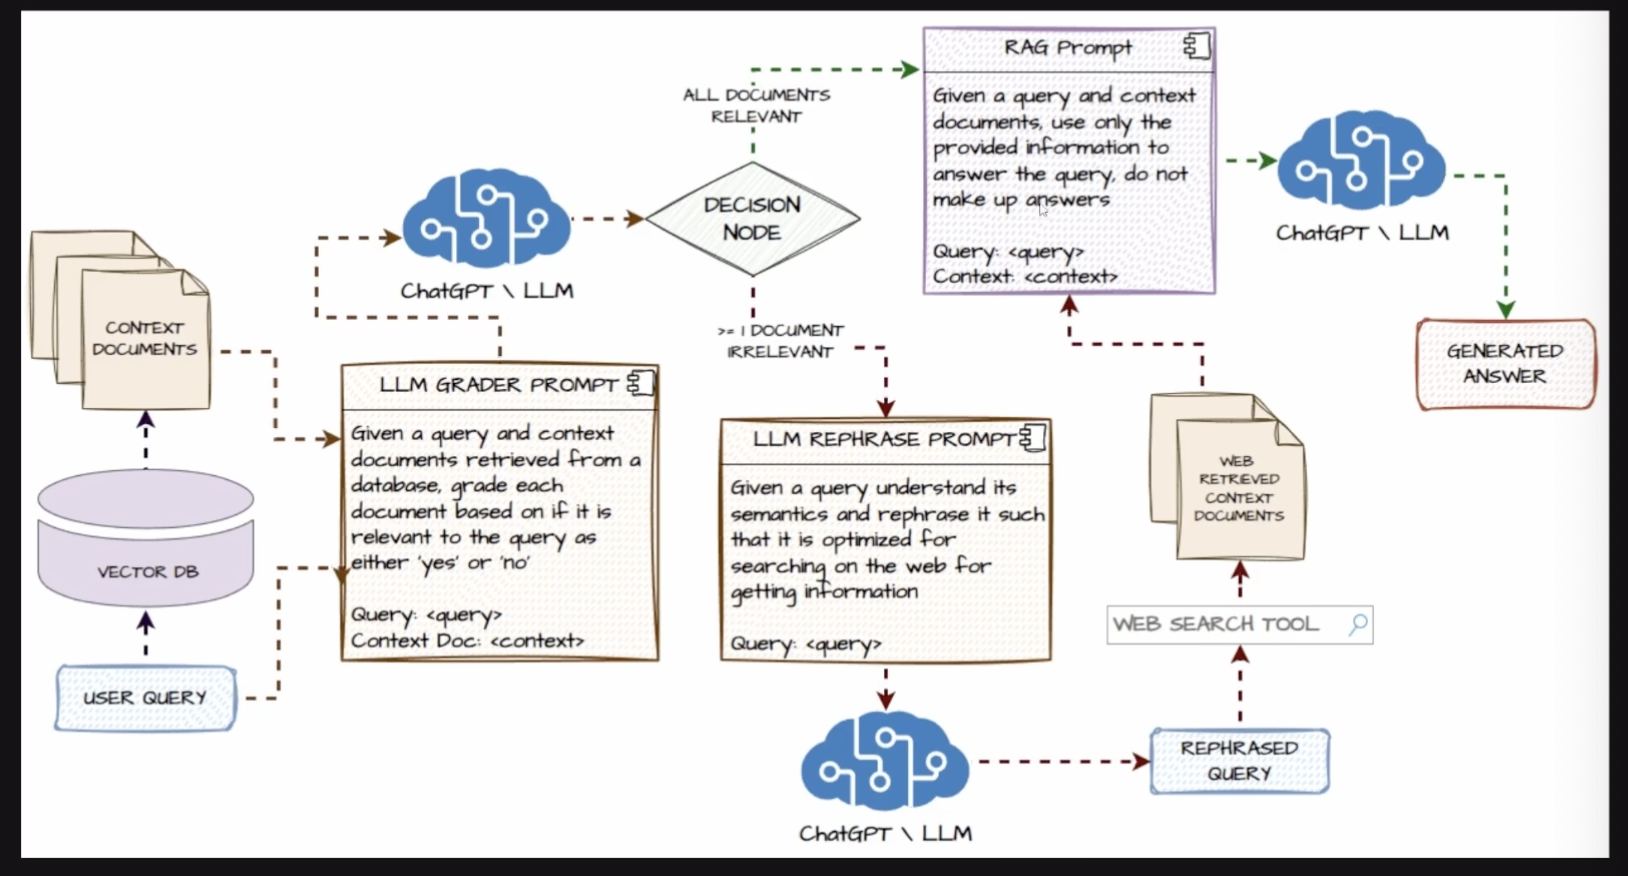

Main Takeaway:
  * If any documents retrieved are irrelevant or do not answer the original query, the LLM is used to rephrase the prompt to then use an agent & tool to search the web and find the correct answer.

# Install dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-chroma==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386

# Enter Open AI API key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


# Enter Tavily Search API key
* Tool for web search

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API key: ')

Enter Tavily Search API key: ··········


# Setup Environment Variables


In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Build Search Index for Wikipedia Data
* We will first build a vector DB for retrieval and search by taking a subset of documents from wikipedia.

## Setup Open AI Embedding Model

In [5]:
## import openai embeddings
from langchain_openai import OpenAIEmbeddings

## load embeddings
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

## Get Data from Wikipedia

In [6]:
## download data
!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

Downloading...
From (original): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW
From (redirected): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW&confirm=t&uuid=5ae9c606-bc6b-40f6-ba29-e88a58b25726
To: /content/simplewiki-2020-11-01.jsonl.gz
100% 50.2M/50.2M [00:00<00:00, 72.6MB/s]


## Load and Chunk Documents

In [7]:
import gzip
import json
from langchain.docstore.document import Document #doc loader from Langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter #text splitter

## wiki file path
wikipedia_filepath = '/content/simplewiki-2020-11-01.jsonl.gz'
## unzip file and extract data and metadata
docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
  for line in fIn:
    data = json.loads(line.strip())
    ## add all paragraphs
    ## passages.extend(data['paragraphs'])
    ## only add first paragraph
    docs.append({
                  'metadata': {
                                    'title': data.get('title'),
                                    'article_id': data.get('id')
                  },
                  'data': ' '.join(data.get('paragraphs')[0:3]) #restrict data to first 3 paragraphs

    })

# subset data to only use portion of wiki docs to run things faster in a notebook
docs = [doc for doc in docs for x in ['boston']
              if x in doc['data'].lower().split()]

# create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]

# chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [8]:
## check len of chunks
len(chunked_docs)

640

In [9]:
## view first 3 docs
chunked_docs[:3]

[Document(metadata={'title': 'Intolerable Acts', 'article_id': '74587'}, page_content='The Intolerable Acts are laws passed by the British Parliament in 1774. The British Parliament passed these laws to punish the Massachusetts colony for the Boston Tea Party. These laws were so harsh that the colonists called them the Intolerable Acts.'),
 Document(metadata={'title': 'Corey Crawford', 'article_id': '259842'}, page_content='Corey Crawford (born December 31, 1984 in Montreal, Quebec) is a Canadian professional ice hockey goaltender. He currently plays for the Chicago Blackhawks of the National Hockey League (NHL). He made his debut with the Blackhawks on January 22, 2006 against the Minnesota Wild. Crawford also played in the QMJHL for the Moncton Wildcats. On June 24, 2013, He won the Stanley Cup with the Blackhawks after they defeated the Boston Bruins 4 games to 2 in the 2013 Stanley Cup Finals.'),
 Document(metadata={'title': 'Charlie Sands (ice hockey)', 'article_id': '259984'}, pa

## Create Vector DB and persist on disk
* Create vector DB and save it so we can load it anytime we want to use it.

In [10]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings -- code takes a bit to run depending on size of docs
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_wikipedia_db',
                                  embedding=openai_embed_model,
                                  collection_metadata={'hnsw:space': 'cosine'}, #defaults to euclidean so need to change to cosine
                                  persist_directory='./wikipedia_db')

## Setup Vector DB Retriever
* Here we will use cosine similarity and retrieve the top 3 similar documents based on a user input query.
* We will also use a threshold cutoff for similarity.

In [11]:
## setup retriever
similarity_threshold_retriever = chroma_db.as_retriever(search_type='similarity_score_threshold',
                                                        search_kwargs={'k': 3,
                                                                       'score_threshold': 0.3})

In [12]:
## query
query = "When was boston settled?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'article_id': '253096', 'title': 'Boston'}, page_content='Boston is the largest city of Massachusetts in the United States. It was founded in 1630. Boston is one of the oldest, richest and most culturally important cities in the United States. Boston was founded on September 7, 1630, by Puritan colonists from England. Boston\'s early European settlers called the area "Trimountaine" (Three Mountains). They renamed the town for Boston, England, in Lincolnshire because many important "Pilgrim" colonists came from there. Most of Boston\'s early citizens were Puritans. Shortly after Boston\'s settlement, Puritans created America\'s first public school and America\'s first university, Harvard University (1636). Harvard is in the city of Cambridge, which is across the Charles River from Boston. Until the 1760s, Boston was America\'s largest city.'),
 Document(metadata={'article_id': '100169', 'title': 'Boston, Lincolnshire'}, page_content='Boston is a town and small port i

In [13]:
## random query
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'article_id': '217967', 'title': 'Robert Lang'}, page_content='Robert Lang (born December 19, 1970 in Teplice, CS) is a Czech retired ice hockey centre. He played a career total of 18 years in the National Hockey League (NHL). He played for the Los Angeles Kings, Boston Bruins, Pittsburgh Penguins, Washington Capitals, Detroit Red Wings, Chicago Blackhawks, Montreal Canadiens, and the Phoenix Coyotes. In 2004, Lang won a Golden Hockey Stick for being the best Czech hockey player.'),
 Document(metadata={'article_id': '791686', 'title': 'Al Langlois'}, page_content='Joseph Albert Oliver "Junior" Langlois (November 6, 1934 – September 19, 2020) was a Canadian ice hockey defenceman. Langlois started his National Hockey League career with the Montreal Canadiens in 1958 and ended in 1966 with the Boston Bruins. He also played with the New York Rangers and Detroit Red Wings. Langlois won three Stanley Cups with Montreal, in 1958, 1959 and 1960. He was born in Magog, Quebec

Summary:
* This is interesting, because we did not setup any guardrails or any corrective RAG we can see the LLM hallucinated and tried to answer the question without "logic" and pulled up the 2 most similar documents to "lang" in our vector DB which contains documents about Boston.
* Obviously these are not correct answers and we will now fix that.

# Create a Query Retrieval Grader
* Here we will use an LLM as a judge to grade if any retrieved document is relevant to the given question -- answer is YES or NO.

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# create data model for LLM output formats
class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""
  binary_score: str = Field(
      description="Documents are relevant to the question, 'yes' or 'no'"
  )

## setup LLM as a judge
llm = ChatOpenAI(model='gpt-4o', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of retrieved documents to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
            """

## create grade prompt
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                      {document}

                      User question:
                      {question}


                  """),

    ]
)

# build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [15]:
## query
query = "When was Boston settled?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
  print(doc.page_content)
  print('GRADE:', doc_grader.invoke({'question': query, 'document': doc.page_content}))
  print()

Boston is the largest city of Massachusetts in the United States. It was founded in 1630. Boston is one of the oldest, richest and most culturally important cities in the United States. Boston was founded on September 7, 1630, by Puritan colonists from England. Boston's early European settlers called the area "Trimountaine" (Three Mountains). They renamed the town for Boston, England, in Lincolnshire because many important "Pilgrim" colonists came from there. Most of Boston's early citizens were Puritans. Shortly after Boston's settlement, Puritans created America's first public school and America's first university, Harvard University (1636). Harvard is in the city of Cambridge, which is across the Charles River from Boston. Until the 1760s, Boston was America's largest city.
GRADE: binary_score='yes'

Boston is a town and small port in Lincolnshire, on the east coast of England.
GRADE: binary_score='no'

Watertown is a city in Middlesex County, Massachusetts, United States. It is par

Observation: We can see the top 3 documents were retrieved but only the first one was the correct answer to the query and the LLM judge was able to figure that out.

In [16]:
## try random query
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
  print(doc.page_content)
  print('GRADE:', doc_grader.invoke({'question': query, 'document': doc.page_content}))
  print()

Robert Lang (born December 19, 1970 in Teplice, CS) is a Czech retired ice hockey centre. He played a career total of 18 years in the National Hockey League (NHL). He played for the Los Angeles Kings, Boston Bruins, Pittsburgh Penguins, Washington Capitals, Detroit Red Wings, Chicago Blackhawks, Montreal Canadiens, and the Phoenix Coyotes. In 2004, Lang won a Golden Hockey Stick for being the best Czech hockey player.
GRADE: binary_score='no'

Joseph Albert Oliver "Junior" Langlois (November 6, 1934 – September 19, 2020) was a Canadian ice hockey defenceman. Langlois started his National Hockey League career with the Montreal Canadiens in 1958 and ended in 1966 with the Boston Bruins. He also played with the New York Rangers and Detroit Red Wings. Langlois won three Stanley Cups with Montreal, in 1958, 1959 and 1960. He was born in Magog, Quebec. Langlois died on September 19, 2020 in California, aged 85.
GRADE: binary_score='no'



Observation:
* Now we can see using the LLM judge it tells us that neither of these documents retrieved are correct.

In [17]:
## query
query = "Who won the stanley cup in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
  print(doc.page_content)
  print('GRADE:', doc_grader.invoke({'question': query, 'document': doc.page_content}))
  print()

The 2013 Stanley Cup Final was the championship series of the National Hockey League (NHL) season. The Western Conference playoff champion Chicago Blackhawks defeated the Eastern Conference playoff champion Boston Bruins in six games. This was the fifth championship for the Blackhawks. Due to the 2012–13 NHL lockout the 2013 Cup Finals began on June 12. The last game was June 24. This tied the , also impacted by a lockout, for the latest in June that the Stanley Cup was awarded. Years in boldface under the "Finals appearance" column signify the player won the Stanley Cup in the given year.
GRADE: binary_score='no'

The 2011 Stanley Cup Finals was the 118th edition of the Stanley Cup. It included the western conference team, the Vancouver Canucks and the Eastern conference champion, the Boston Bruins. Boston beat the Canucks in 7 games to win the Stanley cup. This was their 6th Stanley cup win and they have the #4 most Stanley cups in the NHL league. They played 7 games, ending in Vanco

Observation:
* Again we can see the LLM tried to answer the question with the data we have but the LLM judge was able to discern that none of the 3 docs retrieved are correct and judged them as NO.

# Build a QA RAG Chain
* Now we can connect the retriever to an LLM and build a QA-RAG Chain.

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# prompt
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question only.

            Question:
            {question}

            Context:
            {context}

            Answer:
          """

prompt_template = ChatPromptTemplate.from_template(prompt)

## llm
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## func to format docs
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)


## setup qa rag chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')

    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [19]:
## now query again
query = "When was boston settled?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {'context': top3_docs, 'question': query}
)
print(result)

Boston was settled on September 7, 1630, by Puritan colonists from England.


In [20]:
## now query again
query = "Who won the stanley cup in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {'context': top3_docs, 'question': query}
)
print(result)

I don't know the answer. The provided context does not contain information about the winner of the Stanley Cup in 2024.


Summary:
* Now we can see with this improved infrastructure we get a specific answer for the first query and with details that are correct without irrelevant infor.
* For the 2nd query rather than try to incorrectly answer the question based on information in the vector DB it is able to say "i dont know".

# Create a Query Rephraser
* We will now build a query rephraser which will use an LLM to rephrase the input user query into a better version which is then optimized to use the tavily search tool to search the web and find the answer.
* The concept as we mentioned above is that if some of the documents retrieved are not relevant, we will simply use the LLM to rephrase our query and perform a search using a tool to find the answer.

In [21]:
## LLM setup for question rephrasing
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                - Convert the following input question to a better version that is optimized for web search.
                - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
            """

# create re-writing prompt
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                      {question}

                      Formulate an improved question.
                  """,


        ),
    ]
)

## connect chains
question_rewriter = (re_write_prompt
                        |
                     llm
                        |
                     StrOutputParser())

In [22]:
## now lets try this with the "random query" not in our data
query = "Who won the stanley cup in 2024?"
question_rewriter.invoke({"question": query})

'Who were the winners of the 2024 Stanley Cup?'

# Load Web Search Tool
* Use the tavily API

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults


# setup tavily tool
tv_search = TavilySearchResults(max_results=3,
                                search_depth='advanced',
                                max_tokens=10000)

# Build Agentic RAG Components
* Here we will build the key components of our Agentic Corrective RAG System:
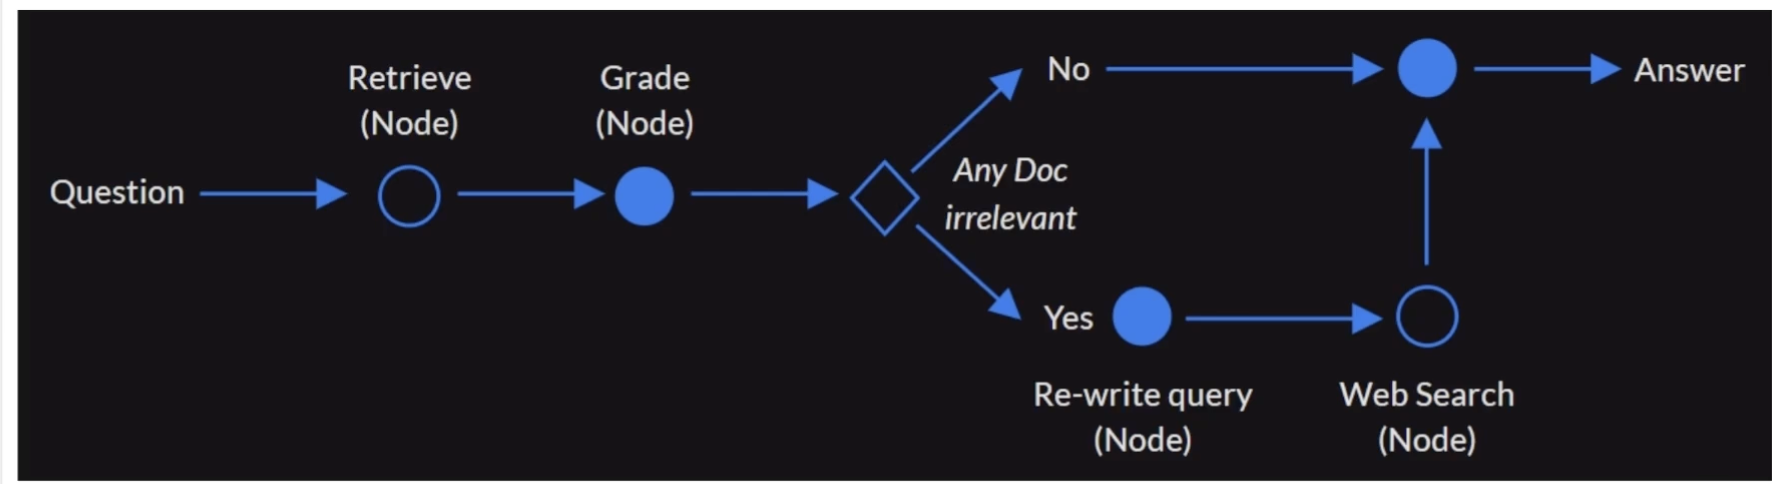

## Graph State
* This is ALWAYS the first step when creating Agentic workflows in LangGraph.
* The Graph State is used to store and represent the state of the agent graph as we move through various nodes.

In [24]:
from typing import List
from typing_extensions import TypedDict

## setup GraphState
class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
      question: question
      generation: LLM response generation
      web_serach_needed: flag of whether to add web search - yes or no
      documents: list of retrieved context documents from vector DB or web search
  """
  #data model --> multiple key-value pairs (stored as a dictionary)
  question: str
  generation: str
  web_search_needed: str
  documents: List[str]

## Retrieve function for retrieval from Vector DB
* This will be used to get relevant context documents from the vector DB.

In [25]:
## function
def retrieve(state):
  """
  Retrieve documents

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): New key added to state, documents - that contains retrieved context documents
  """
  print("---RETRIEVAL FROM VECTOR DB---")
  question = state['question']

  # Retrieval
  documents = similarity_threshold_retriever.invoke(question)
  return {'documents': documents, 'question': question}

## Grade documents
* This is used to determine if the retrieved docs are relevant to the question by using the LLM Grader.
* It sets `web_search_needed` flag as `Yes` if at least one doc is not contextually relevant and sets it as `No` if all docs are contextually relevant to the given user query.

In [26]:
## grade docs function
def grade_documents(state):
  """
  Determines whether the retrieved docs are relevant to the question
  by using an LLM Grader.

  If any documents are not relevant to question or documents are empty - Web Search needs to be performed
  If all documents are relevant to question - Web Search is not needed
  Helps filtering out irrelevant documents

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): Updates documents key with only filtered relevant documents
  """
  # extract questions and docs from graph state
  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state['question']
  documents = state['documents']

  # Score each doc
  filtered_docs = []
  web_search_needed = "No"
  if documents:
    for d in documents:
      score = doc_grader.invoke(
          {'question': question, 'document': d.page_content}
      )
      grade = score.binary_score
      if grade == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
      else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        web_search_needed = "Yes"
        continue

  else:
    print("---NO DOCUMENTS RETRIEVED---")
    web_search_needed = "Yes"

  return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

## Rewrite query
* This will be used to rewrite the input query to produce a better question optimized for web search using an LLM.

In [27]:
## node (function) to rewrite query
def rewrite_query(state):
  """
  Rewrite the query to produce a better question.

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): Updates question key with a re-phrased or re-written question
  """

  print("---REWRITE QUERY---")
  question = state['question']
  documents = state['documents']

  # re-write question
  better_question = question_rewriter.invoke({'question': question})
  return {'documents': documents, 'question': better_question}

## Web Search
* This node will be used to search the web using the tavily web search tool for the given query and retrieve some info which can be used as the context in RAG.

In [28]:
from langchain.schema import Document

# web search node
def web_search(state):
  """
  Web search based on re-written question.

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): Updates documents key with appended web results
  """

  print("---WEB SEARCH---")
  question = state['question']
  documents = state['documents']

  # web search
  docs = tv_search.invoke(question)
  web_results = "\n\n".join([d['content'] for d in docs])
  web_results = Document(page_content=web_results)
  documents.append(web_results)

  return {"documents": documents, "question": question}



## Generate Answer
* Standard LLM response generation from query and context docs in a RAG system.

In [29]:
## node to generate answer
def generate_answer(state):
  """
  Generate answer from context document using LLM

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): New key added to state generation that contains LLM generation
  """
  print("---GENERATE ANSWER---")
  question = state['question']
  documents = state['documents']

  # RAG generation
  generation = qa_rag_chain.invoke({'context': documents, 'question': question})
  return {'documents': documents, 'question': question, 'generation': generation}


## Decided to Generate
* This node is used as a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called.

In [30]:
## node for decide to generate
def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question.

  Args:
      state (dict): The current graph state

  Returns:
      str: Binary decision for next node to call
  """

  print("---ASSESS GRADED DOCUMENTS---")
  web_search_needed = state['web_search_needed']

  if web_search_needed == "Yes":
    # All docs have been filtered check_relevance
    # we will re-generate a new query
    print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
    return "rewrite_query"
  else:
    # we have relevant docs so generate answer!
    print("---DECISION: GENERATE RESPONSE---")
    return "generate_answer"



## Build the Agent Graph
* Now that all conditional logic is built (nodes), we can build the edges the graph should traverse.

In [31]:
from langgraph.graph import END, StateGraph

#init state graph --> first step (class dict we created of key-val pairs)
agentic_rag = StateGraph(GraphState)

# define nodes
agentic_rag.add_node("retrieve", retrieve) # retrieve node
agentic_rag.add_node("grade_documents", grade_documents) # grade documents node
agentic_rag.add_node("rewrite_query", rewrite_query) # transform query node
agentic_rag.add_node("web_search", web_search) # web search node
agentic_rag.add_node("generate_answer", generate_answer) # generate answer node

# Build graph
agentic_rag.set_entry_point("retrieve") #entry point
agentic_rag.add_edge("retrieve", "grade_documents") #grade retrieved docs
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},

)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END) #end

# compile graph
agentic_rag = agentic_rag.compile()


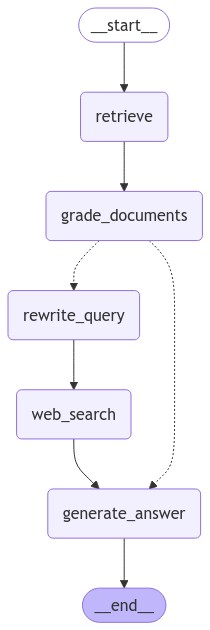

In [32]:
##display mermaid diagram
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

# Test Agentic CRAG System

In [33]:
query = "When was boston settled?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [34]:
#display
display(Markdown(response['generation']))

Boston was first established as a settlement in the year 1630 by a Protestant religious sect called the Puritans.

In [35]:
response

{'question': 'What year was Boston first established as a settlement?',
 'generation': 'Boston was first established as a settlement in the year 1630 by a Protestant religious sect called the Puritans.',
 'web_search_needed': 'Yes',
 'documents': [Document(page_content="Boston was founded in 1630 by a Protestant religious sect called the Puritans. They named the new town for their former home in Lincolnshire, England. The same year, Boston was declared the capital of the Massachusetts Bay Colony. Bounded on three sides by water, Boston soon became the colonies' major New England seaport and the largest British\n\nLocal Histories\nTim's History of British Towns, Cities and So Much More\nA History of Boston Massachusetts\nBy Tim Lambert\n17th Century Boston\nBoston was founded in 1630 by English Puritans fleeing religious persecution. In 1630 the new settlement was named Boston after Boston in England from which many of the settlers came.\n Last revised 2024\nShare this:\nRelated\nPost n

We can see all the documents retrieved to answer the question.

In [36]:
## try an out of vocabulary query -- not in our vector db
query = "Who is running for president in 2024?"
response = agentic_rag.invoke({'question': query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [37]:
#display output
display(Markdown(response['generation']))

The candidates running for the 2024 U.S. presidential election are former President Donald Trump, who is the Republican presidential nominee, and Vice President Kamala Harris, who is the Democratic nominee.

In [38]:
## now lets go back to the data in the vector DB
query = "Tell me about Southie"
response = agentic_rag.invoke({'question': query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [39]:
#display output
display(Markdown(response['generation']))

South Boston, commonly known as Southie, is a neighborhood in Boston, Massachusetts, with a rich and evolving history. Originally annexed to Boston in 1804, Southie was primarily farmland before undergoing significant demographic changes over the years. In the 20th century, it became known for its vibrant community and cultural identity.

One of the key historical landmarks in Southie is Castle Island, which has played a significant role in Boston's maritime heritage. Castle Island has been a strategic defense point for the harbor, protecting it from enemy forces. Over time, it has transformed into a popular recreational area, offering beautiful views of the harbor and serving as a reminder of the area's historical significance.

Today, Southie is known for its lively atmosphere and stunning waterfront. It offers unique experiences such as distillery tours at GrandTen Distilling, where visitors can learn about craft spirits. The neighborhood's history and its ongoing transformation make it a significant part of Boston's cultural and historical landscape.

In [40]:
response

{'question': 'What is the history and significance of Southie in Boston?',
 'generation': "South Boston, commonly known as Southie, is a neighborhood in Boston, Massachusetts, with a rich and evolving history. Originally annexed to Boston in 1804, Southie was primarily farmland before undergoing significant demographic changes over the years. In the 20th century, it became known for its vibrant community and cultural identity.\n\nOne of the key historical landmarks in Southie is Castle Island, which has played a significant role in Boston's maritime heritage. Castle Island has been a strategic defense point for the harbor, protecting it from enemy forces. Over time, it has transformed into a popular recreational area, offering beautiful views of the harbor and serving as a reminder of the area's historical significance.\n\nToday, Southie is known for its lively atmosphere and stunning waterfront. It offers unique experiences such as distillery tours at GrandTen Distilling, where visito

Summary:
* We can see the semantic query of asking about "Southie' otherwise known as south Boston and the model was able to retrieve the information from the vector DB as well as contextual search using the web search tool.
* The great thing about this framework is that you can query your vector DB as well as search the web or use another API tool to complement what is or is not in your vector DB to answer a users query.
* This is MORE ideal than leaving an LLM on its own to hallucinate an answer when it does not have all the information it needs.